In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

In [3]:
# Preview the training data
print("Training data:")
print(train.head())
print("\n")  
# Preview the testing data
print("\nTesting data:")
print(test.head())

Training data:
   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  

In [4]:
# checking the number of rows and columns
num_train_rows, num_train_columns = train.shape
num_test_rows, num_test_columns = test.shape
num_submission_rows, num_submission_columns = sample_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}\n")

Training Data:
Number of Rows: 165034
Number of Columns: 14

Test Data:
Number of Rows: 110023
Number of Columns: 13

Submission Data:
Number of Rows: 110023
Number of Columns: 2



In [5]:
# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [6]:
train_duplicate = train.drop("id", axis=1).duplicated().sum()
test_duplicate = test.drop("id", axis=1).duplicated().sum()

print(f"Duplicate count in Training Data: {train_duplicate}")
print(f"Duplicate count in Test Data: {test_duplicate}")

Duplicate count in Training Data: 0
Duplicate count in Test Data: 0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


In [9]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


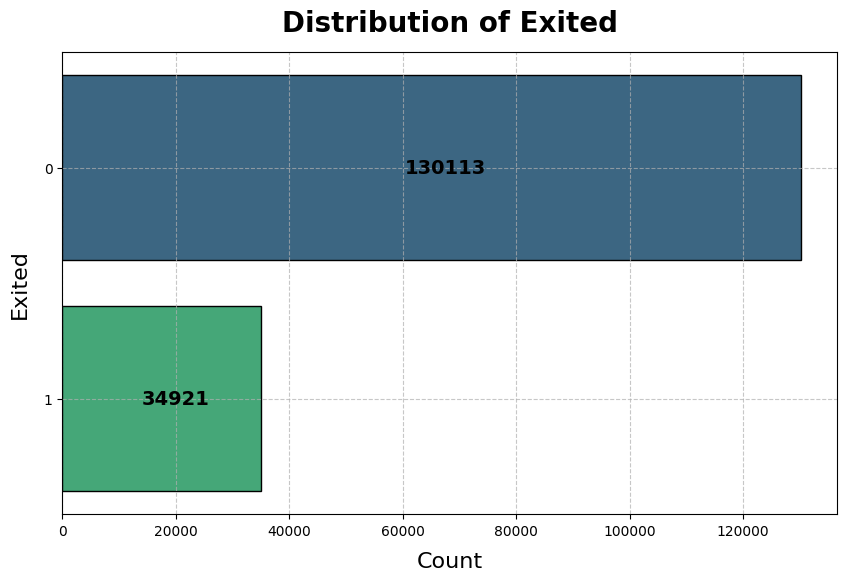

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="Exited", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of Exited", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

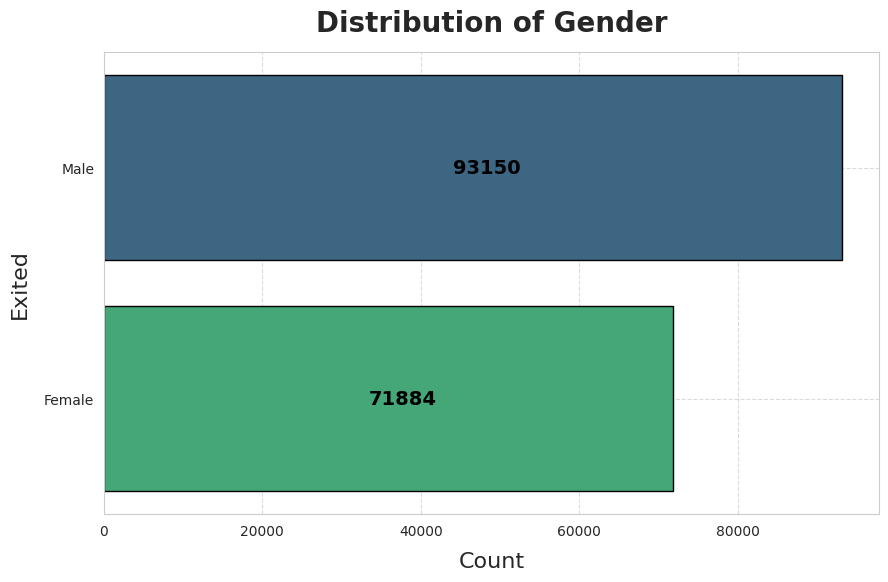

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="Gender", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of Gender", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

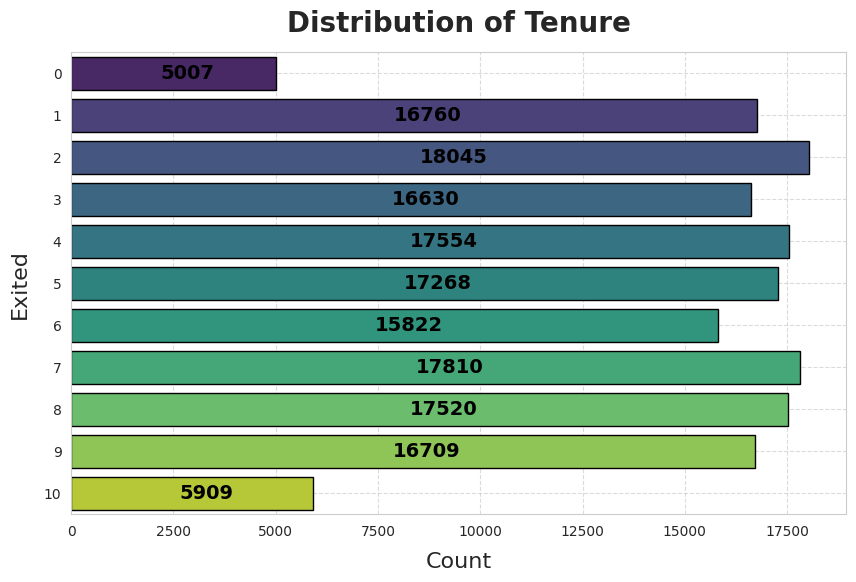

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="Tenure", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of Tenure", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

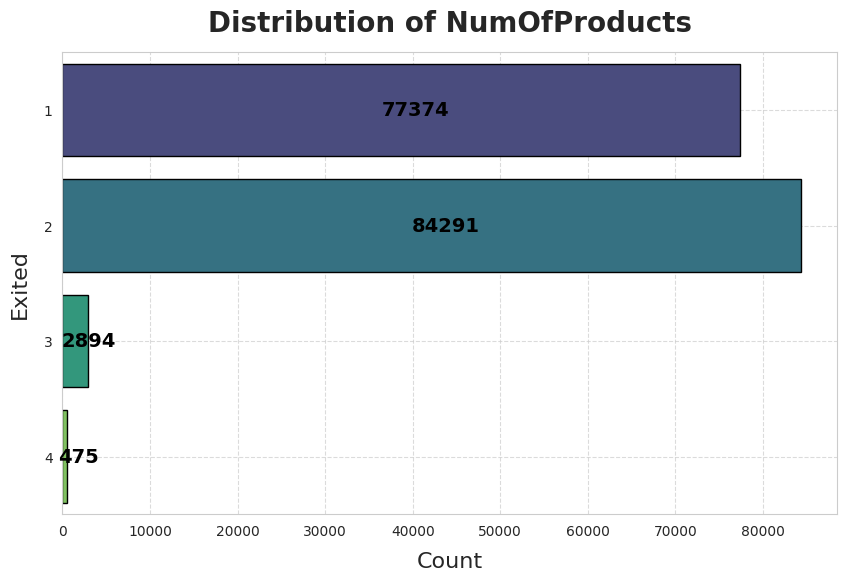

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="NumOfProducts", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of NumOfProducts", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

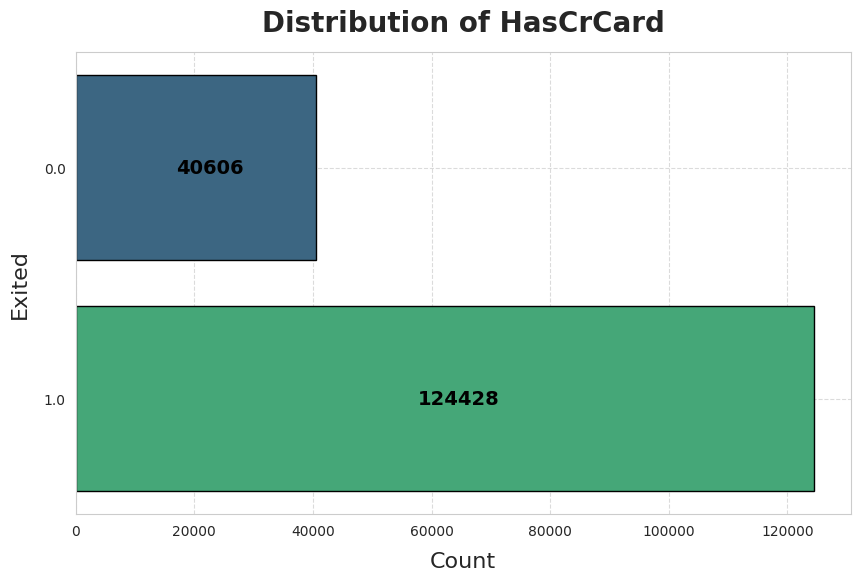

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="HasCrCard", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of HasCrCard", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

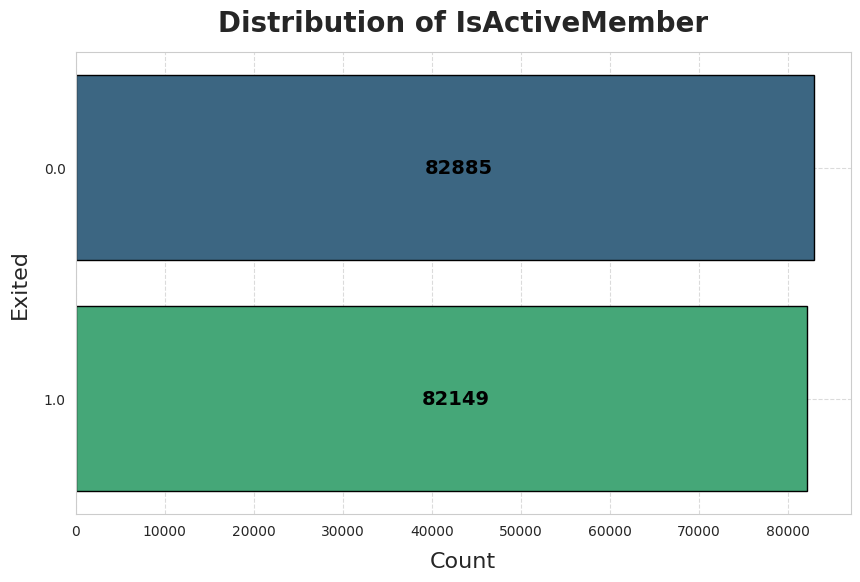

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="IsActiveMember", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of IsActiveMember", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

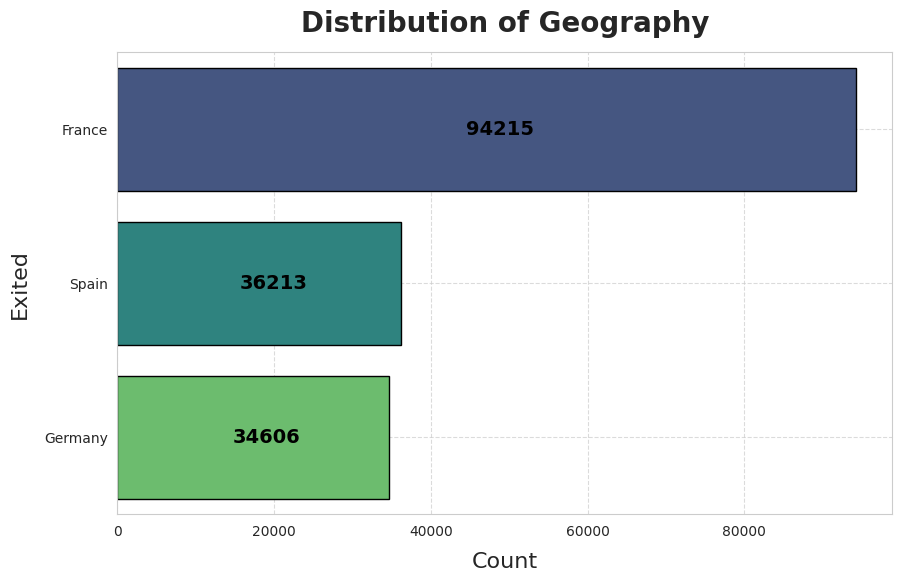

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the count plot with a different color palette and horizontal bars
sns.countplot(y="Geography", data=train, ax=ax, palette="viridis", edgecolor='black')

# Customize the plot
ax.set_title("Distribution of Geography", fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel("Count", fontsize=16, labelpad=10)
ax.set_ylabel("Exited", fontsize=16, labelpad=10)

# Add value labels to the bars with different styling
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=14, padding=10, color='black', fontweight='bold')

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set the background style
sns.set_style("whitegrid")

plt.show()

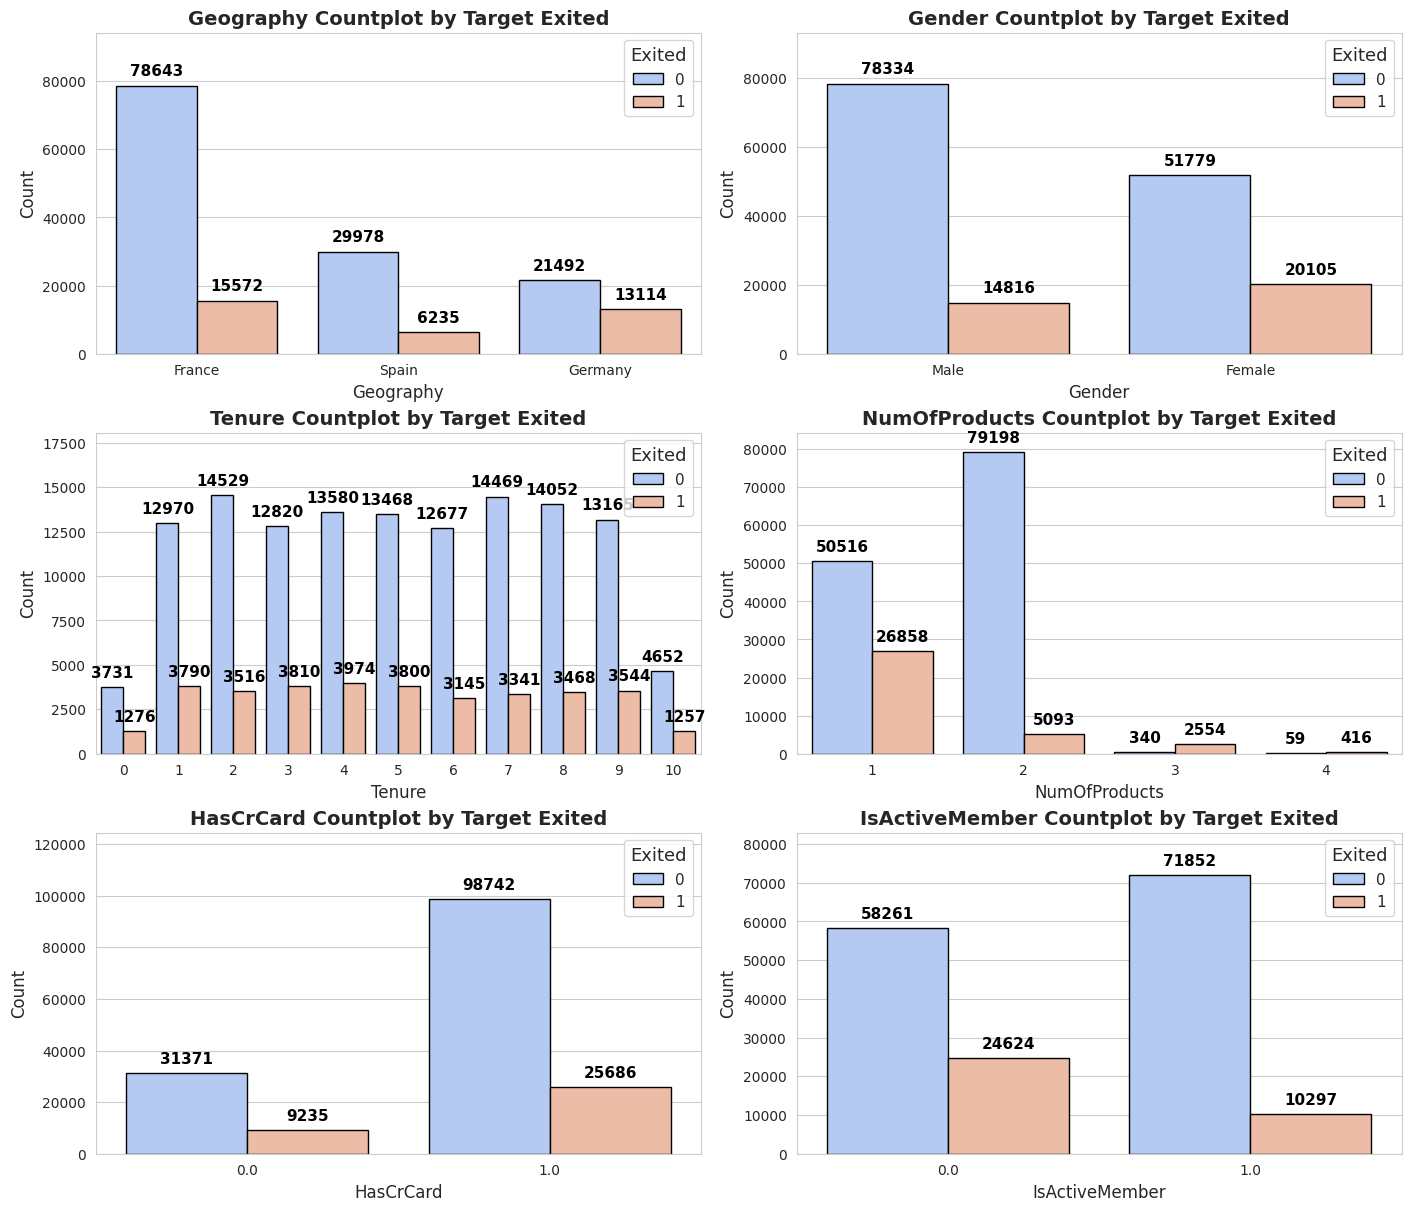

In [17]:
# Define categorical columns and target
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
target = 'Exited'

# Create the figure with adjusted size
fig, axes = plt.subplots(nrows=(len(cat_cols) + 1) // 2, ncols=2, figsize=(14, len(cat_cols)*2), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define color palettes
palette = sns.color_palette("coolwarm", 2)  # Coolwarm for target classes

# Plot each categorical variable
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue=target, data=train, palette=palette, edgecolor='black', ax=axes[i])
    axes[i].set_title(f"{col} Countplot by Target {target}", fontweight='bold', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].legend(title=target, title_fontsize='13', fontsize='11')
    axes[i].set_ylim(0, train[col].value_counts().max() + 15)  # Adjust y-axis limit for visibility
    
    # Annotate the bars with counts
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontsize=11, color='black', padding=5, weight='bold')

# Hide any unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].axis('off')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

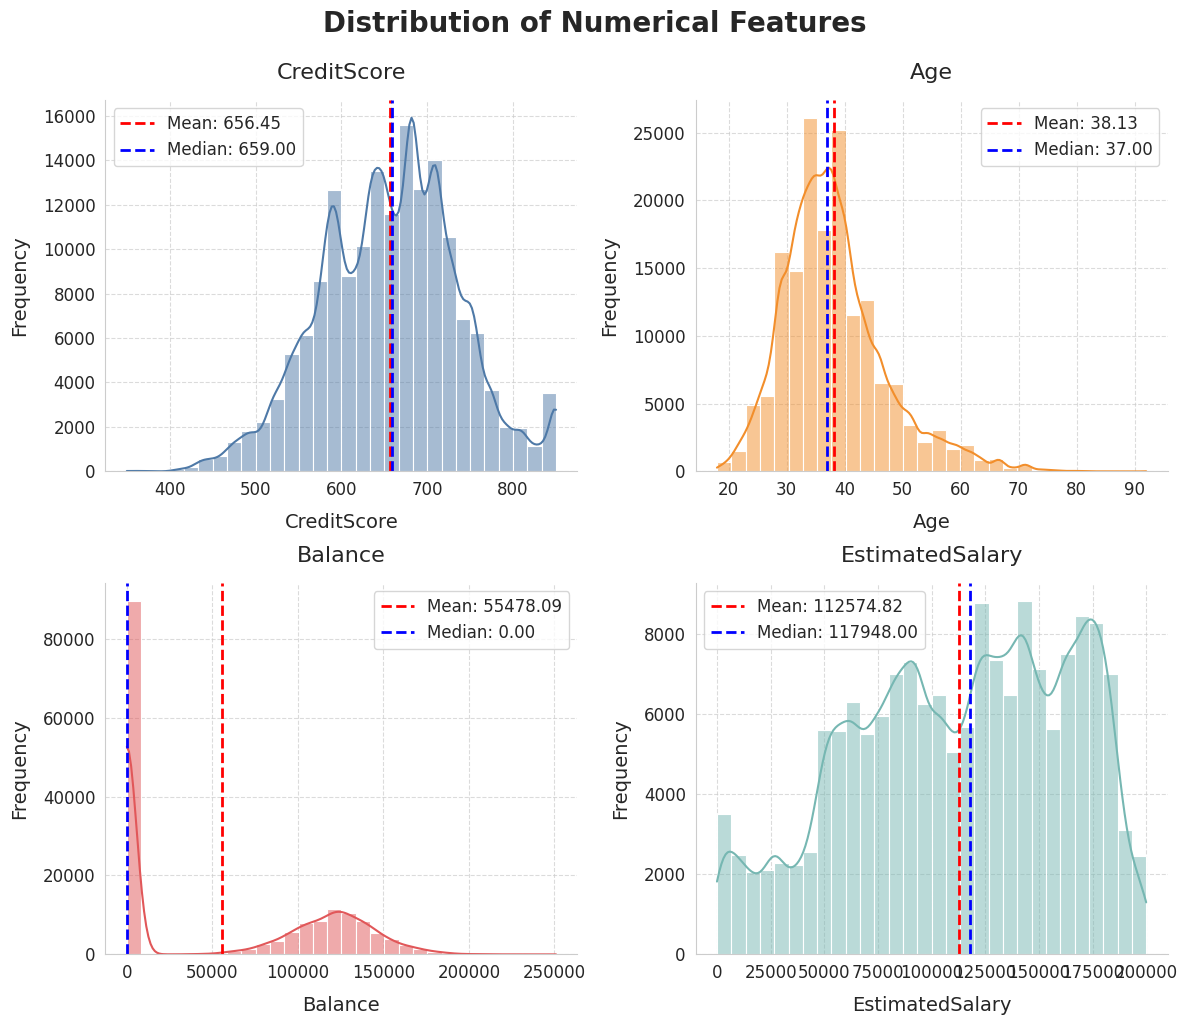

In [18]:
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Distribution of Numerical Features", fontsize=20, fontweight='bold', y=1.02)

for i, column in enumerate(num_cols):
    ax = axes[i//2, i%2]
    sns.histplot(data=train, x=column, kde=True, bins=30, ax=ax, color=colors[i], edgecolor='white', linewidth=0.8)
    
    mean, median = train[column].mean(), train[column].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

    ax.set_title(column, fontsize=16, pad=15)
    ax.set_xlabel(column, fontsize=14, labelpad=10)
    ax.set_ylabel('Frequency', fontsize=14, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)

plt.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.3, wspace=0.25)
plt.show()

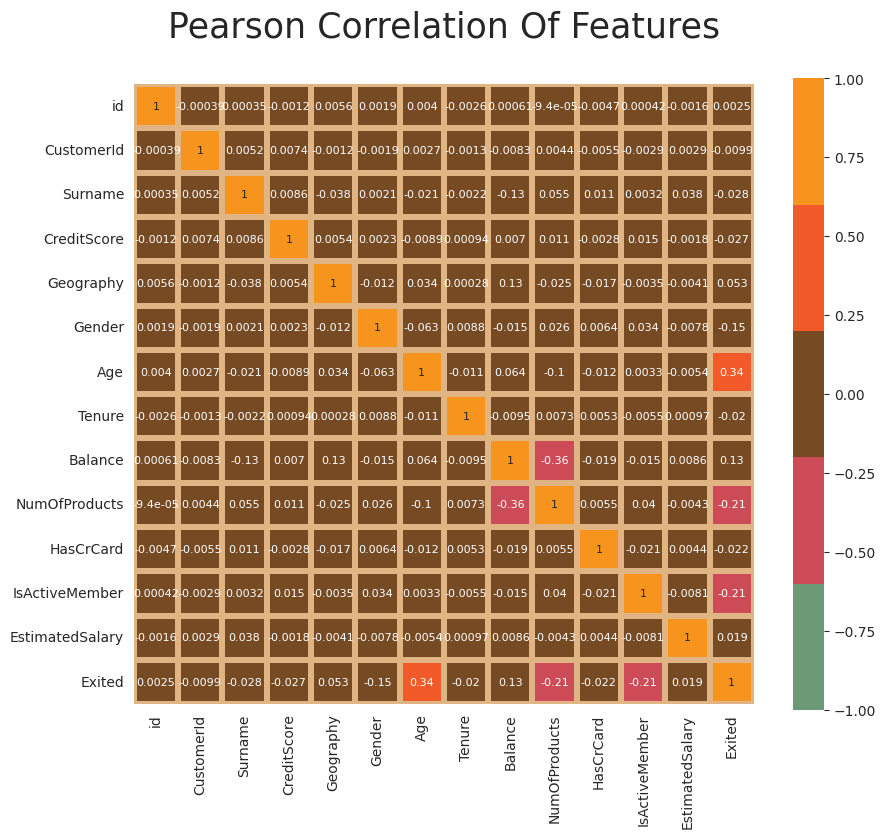

In [19]:
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]
corr = train.copy()

catcol = [col for col in corr.columns if corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        corr[col] = le.fit_transform(corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =8))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [20]:
numeirc_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
#Use Loop Function
for col in numeirc_cols:
    sc = MinMaxScaler()
    train[col+"_scaled"] = sc.fit_transform(train[[col]])
    test[col+"_scaled"] = sc.fit_transform(test[[col]])

In [21]:
# Combining Customerid, Surname, Geography, and Gender, Estimated Slaray and Making New Column in both Data Frames 
train['Sur_Geo_Gend_Sal'] = train['CustomerId'].astype('str') + train['Surname'] + train['Geography'] + train['Gender'] + np.round(train.EstimatedSalary).astype('str')
test['Sur_Geo_Gend_Sal'] = test['CustomerId'].astype('str') + test['Surname'] + test['Geography'] + test['Gender'] + np.round(test.EstimatedSalary).astype('str')

In [22]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test

In [23]:
train,test = get_vectors(train,test,'Surname')
train,test = get_vectors(train,test,'Sur_Geo_Gend_Sal')

In [24]:
# Head Of Train after Vectorization
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0.636,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,-1.087877e-07,-1.680604e-07,-1.089576e-06,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0.554,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,-5.596766e-08,1.417266e-07,2.301584e-06,0.0,0.0,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0.656,0.000000,0.924364,15694510HsuehFranceMale184867.0,5.030047e-05,6.660921e-04,6.733118e-03,0.0,0.0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0.462,0.593398,0.422787,15741417KaoFranceMale84561.0,-2.757944e-04,4.324637e-05,-4.665791e-03,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0.732,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,-2.481613e-07,8.996239e-08,-2.069356e-07,0.0,0.0,0.0


In [26]:
print("Columns before transformation:", train.columns)

Columns before transformation: Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Sur_Geo_Gend_Sal', 'Surname_tfidf_0', 'Surname_tfidf_1',
       'Surname_tfidf_2', 'Sur_Geo_Gend_Sal_tfidf_0',
       'Sur_Geo_Gend_Sal_tfidf_1', 'Sur_Geo_Gend_Sal_tfidf_2'],
      dtype='object')


In [27]:
def feature_data(df):
    
    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    #onehotEncoding
    df=pd.get_dummies(df,columns=cat_cols)
    return df

In [28]:
#Genrating New Features
train = feature_data(train)
test = feature_data(test)

##Selecting Columns FOr use 
feat_cols = train.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols = feat_cols.drop(numeirc_cols)

#Printing
print(feat_cols)
train.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'Senior', 'Active_by_CreditCard',
       'Products_Per_Tenure', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,True,False,True,False,False,False,True,False,False,False


In [29]:
X=train[feat_cols]
y=train['Exited']

In [30]:
print(f'The Shape Of X is {X.shape}')
print(f'The Shape Of y is {y.shape}')

The Shape Of X is (165034, 30)
The Shape Of y is (165034,)


In [34]:
# RandomForestClassifier 
RFC_model = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_cv_scores = cross_val_score(RFC_model, X, y, cv=10, scoring='roc_auc')

print("Cross-validation scores:", RFC_cv_scores)
print("Mean AUC:", RFC_cv_scores.mean())

Cross-validation scores: [0.8769962  0.8831263  0.87479378 0.87603561 0.8793645  0.87402815
 0.87552635 0.87650867 0.87602047 0.87588667]
Mean AUC: 0.876828670684694


In [44]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_cv_scores = cross_val_score(gbc, X, y, cv=10, scoring='roc_auc')

print("Gradient Boosting - Cross-validation scores:", gbc_cv_scores)
print("Gradient Boosting - Mean AUC:", gbc_cv_scores.mean())

Gradient Boosting - Cross-validation scores: [0.88912617 0.89547892 0.88785727 0.88681598 0.89157279 0.88766244
 0.88797058 0.88911208 0.8887614  0.88864508]
Gradient Boosting - Mean AUC: 0.8893002695814035


In [46]:
# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=10, scoring='roc_auc')

print("XGBoost - Cross-validation scores:", xgb_cv_scores)
print("XGBoost - Mean AUC:", xgb_cv_scores.mean())


XGBoost - Cross-validation scores: [0.8903741  0.89799322 0.88942603 0.88894132 0.89366048 0.88846498
 0.89128486 0.89113799 0.88966606 0.89012441]
XGBoost - Mean AUC: 0.8911073442090002


In [38]:
import os

# Define the file path
file_path = 'submission/RFC_submission.csv'

# Check if the file exists, then remove it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File removed: {file_path}")
else:
    print(f"File not found: {file_path}")

File not found: submission/RFC_submission.csv


In [39]:
# before prediction we need to fit the data
RFC_model.fit(X,y)

test_predictions = RFC_model.predict_proba(test[feat_cols])[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'Exited': test_predictions
})


import os

# Create the directory if it doesn't exist
if not os.path.exists('submission'):
    os.makedirs('submission')

# Now save the submission file
submission.to_csv('submission/RFC_submission.csv', index=False)

print("Submission file created: RFC_submission.csv")

Submission file created: RFC_submission.csv


In [47]:
# before prediction we need to fit the data
gbc.fit(X,y)

test_predictions = gbc.predict_proba(test[feat_cols])[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'Exited': test_predictions
})


import os

# Create the directory if it doesn't exist
if not os.path.exists('submission'):
    os.makedirs('submission')

# Now save the submission file
submission.to_csv('submission/gbc_submission.csv', index=False)

print("Submission file created: gbc_submission.csv")

Submission file created: gbc_submission.csv


In [48]:
# before prediction we need to fit the data
xgb_model.fit(X,y)

test_predictions = xgb_model.predict_proba(test[feat_cols])[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'Exited': test_predictions
})


import os

# Create the directory if it doesn't exist
if not os.path.exists('submission'):
    os.makedirs('submission')

# Now save the submission file
submission.to_csv('submission/xgb_submission.csv', index=False)

print("Submission file created: xgb_submission.csv")

Submission file created: xgb_submission.csv
